In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
try:
    from ucimlrepo import fetch_ucirepo
except ImportError:
    print("Please install the ucimlrepo with pip :)")

In [4]:
# fetch dataset 
cirrhosis_patient_survival_prediction = fetch_ucirepo(id=878) 
  
# data (as pandas dataframes) 
X = cirrhosis_patient_survival_prediction.data.features 
  
# metadata 
print(cirrhosis_patient_survival_prediction.metadata) 
  
# variable information 
print(cirrhosis_patient_survival_prediction.variables)

data = pd.DataFrame(X)

print(data.head())

#data preparation and cleaning

data = data.replace('NaNN', np.nan)

cols = data.columns

na_per_col = {}

for col in cols:
    na_per_col[col] = data[col].isna().sum()


for key, value in na_per_col.items():
    print(key, value)

{'uci_id': 878, 'name': 'Cirrhosis Patient Survival Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/878/cirrhosis+patient+survival+prediction+dataset-1', 'data_url': 'https://archive.ics.uci.edu/static/public/878/data.csv', 'abstract': 'Utilize 17 clinical features for predicting survival state of patients with liver cirrhosis. The survival states include 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation).', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 418, 'num_features': 17, 'feature_types': ['Real', 'Categorical'], 'demographics': ['Age', 'Sex'], 'target_col': ['Status'], 'index_col': ['ID'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5R02G', 'creators': ['E. Dickson', 'P. Grambsch', 'T. Fleming', 'L. Fisher', 'A. Langworthy'], 'intro_paper': {'ID': 296, 'type'

In [7]:
data['Drug'].replace(['D-penicillamine', 'Placebo'], [1, 0], inplace=True)
data['Sex'].replace(['F', 'M'], [0, 1], inplace=True)
data['Ascites'].replace(['N', 'Y'], [0, 1], inplace=True)
data['Hepatomegaly'].replace(['N', 'Y'], [0, 1], inplace=True)
data['Spiders'].replace(['N', 'Y'], [0, 1], inplace=True)
data['Edema'].replace(['N', 'Y', 'S'], [0, 1, 2], inplace=True)
print(data.describe())

             Drug           Age         Sex     Ascites  Hepatomegaly  \
count  312.000000    418.000000  418.000000  312.000000    312.000000   
mean     0.506410  18533.351675    0.105263    0.076923      0.512821   
std      0.500762   3815.845055    0.307260    0.266897      0.500639   
min      0.000000   9598.000000    0.000000    0.000000      0.000000   
25%      0.000000  15644.500000    0.000000    0.000000      0.000000   
50%      1.000000  18628.000000    0.000000    0.000000      1.000000   
75%      1.000000  21272.500000    0.000000    0.000000      1.000000   
max      1.000000  28650.000000    1.000000    1.000000      1.000000   

          Spiders       Edema   Bilirubin     Albumin      Alk_Phos  \
count  312.000000  418.000000  418.000000  418.000000    312.000000   
mean     0.288462    0.258373    3.220813    3.497440   1982.655769   
std      0.453775    0.634907    4.407506    0.424972   2140.388824   
min      0.000000    0.000000    0.300000    1.960000    2

In [8]:
data.drop(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], axis=1, inplace=True)

data = data.dropna()

data.describe()

ints = ['Age', 'Copper', 'Platelets', 'Cholesterol', 'Tryglicerides']

for i in ints:
    print(i)
    data[i] = list(map(int, data[i]))

Age
Copper
Platelets
Cholesterol
Tryglicerides


In [10]:
# Extract attribute names (1st row, column 4 to 12)
attributeNames = list(data.columns)

# Extract class names to python list
classLabels = sorted(set(data.Age))
y = data.Age

# Preallocate memory, then extract excel data to matrix X
X = np.empty((len(data), 10))
for i, col_id in enumerate(range(1,11)):
    X[:, i] = np.asarray(data.iloc[:, col_id])

# Compute values of N, M and C.
N = len(y)
M = len(attributeNames)
C = len(classLabels)


# Preallocate memory, then extract excel data to matrix X
X = np.empty((len(data), 10))
for i, col_id in enumerate(range(0,10)):
    X[:, i] = np.asarray(data.iloc[:, col_id])

scaler = StandardScaler()
Y_scaled = scaler.fit_transform(X)

# Subtract mean value from data
Y_scaled = Y_scaled - np.ones((N, 1)) * Y_scaled.mean(0)

In [11]:
import warnings
warnings.filterwarnings("ignore")

Cross-validation fold: 1/10
Cross-validation fold: 2/10
Cross-validation fold: 3/10
Cross-validation fold: 4/10
Cross-validation fold: 5/10
Cross-validation fold: 6/10
Cross-validation fold: 7/10
Cross-validation fold: 8/10
Cross-validation fold: 9/10
Cross-validation fold: 10/10
Best lambda: 75.89999999999999, with validation error: 0.893874064153475


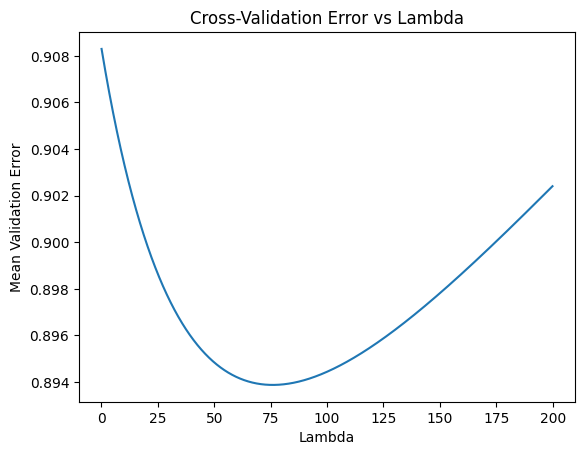

In [14]:
from sklearn import model_selection
import numpy as np
import sklearn.linear_model
import sklearn.neural_network

K1 = 10

X = Y_scaled[:,1:]
y = Y_scaled[:,0]

k1 = 0
k2 = 0

lambda_range = list(np.arange(0.1, 200, 0.1))

test_lens = []

validation_errors = []

for fold_index, (train_index, val_index) in enumerate(model_selection.KFold(K1).split(X)):
    print(f"Cross-validation fold: {fold_index + 1}/{K1}")


    # Split the data into training and validation sets
    X_train, X_val = X[train_index, :], X[val_index, :]
    y_train, y_val = y[train_index], y[val_index]

    # List to store validation errors for each lambda value
    fold_errors = []

    # Train and validate the model for different values of lambda
    for l in lambda_range:
        # Train Ridge regression model
        model = sklearn.linear_model.Ridge(alpha=l).fit(X_train, y_train)
        
        # Make predictions on the validation set
        predictions = model.predict(X_val)
        
        # Calculate the Mean Squared Error (MSE) on the validation set
        mse = np.mean((predictions - y_val) ** 2)
        
        # Store the error for this value of lambda
        fold_errors.append(mse)
    
    # Store the validation errors for this fold (across different lambda values)
    validation_errors.append(fold_errors)




# Convert the list of validation errors into a numpy array
validation_errors = np.array(validation_errors)

# Calculate the mean validation error for each lambda value across all folds
mean_validation_errors = np.mean(validation_errors, axis=0)

# Find the lambda with the lowest validation error
best_lambda_index = np.argmin(mean_validation_errors)
best_lambda = lambda_range[best_lambda_index]
best_error = mean_validation_errors[best_lambda_index]

print(f"Best lambda: {best_lambda}, with validation error: {best_error}")

# Optionally, you can plot the validation error as a function of lambda to visualize the results
import matplotlib.pyplot as plt

plt.plot(lambda_range, mean_validation_errors)
plt.xlabel('Lambda')
plt.ylabel('Mean Validation Error')
plt.title('Cross-Validation Error vs Lambda')
plt.show()

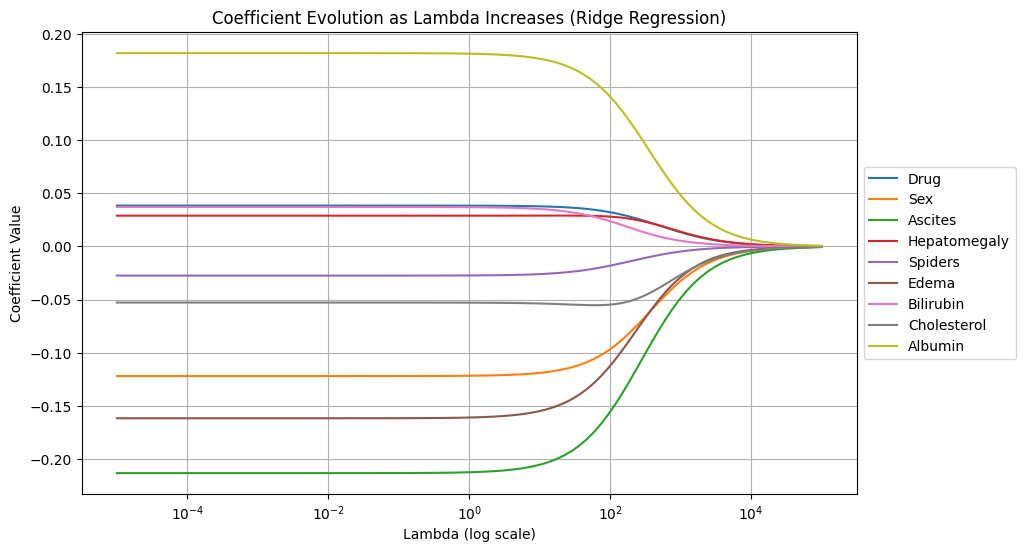

In [25]:
# Example: After scaling data as in previous steps
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define feature names based on your dataset
feature_names = [
    'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 
    'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 
    'Alk_Phos', 'SGOT', 'Triglycerides', 'Platelets', 
    'Prothrombin', 'Stage'
]  # Adjust according to actual feature names in your dataset

# Range of lambda (alpha) values
lambda_range = np.logspace(-5, 5, 100)  # Log scale from 1e-5 to 1e5

# Initialize list to store coefficients for each lambda
coefficients = []

# Loop over lambda values and fit the Ridge model
for lambda_value in lambda_range:
    ridge_model = sklearn.linear_model.Ridge(alpha=lambda_value)
    ridge_model.fit(X_scaled, y)
    coefficients.append(ridge_model.coef_)

# Convert the coefficients list to a numpy array for easier manipulation
coefficients = np.array(coefficients)

# Plot the coefficients as a function of lambda
plt.figure(figsize=(10, 6))
for i in range(X_scaled.shape[1]):  # Loop through all features
    plt.plot(lambda_range, coefficients[:, i], label=feature_names[i])

plt.xscale('log')  # Log scale for lambda
plt.xlabel('Lambda (log scale)')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Evolution as Lambda Increases (Ridge Regression)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Puts legend outside of plot area
plt.grid(True)
plt.show()